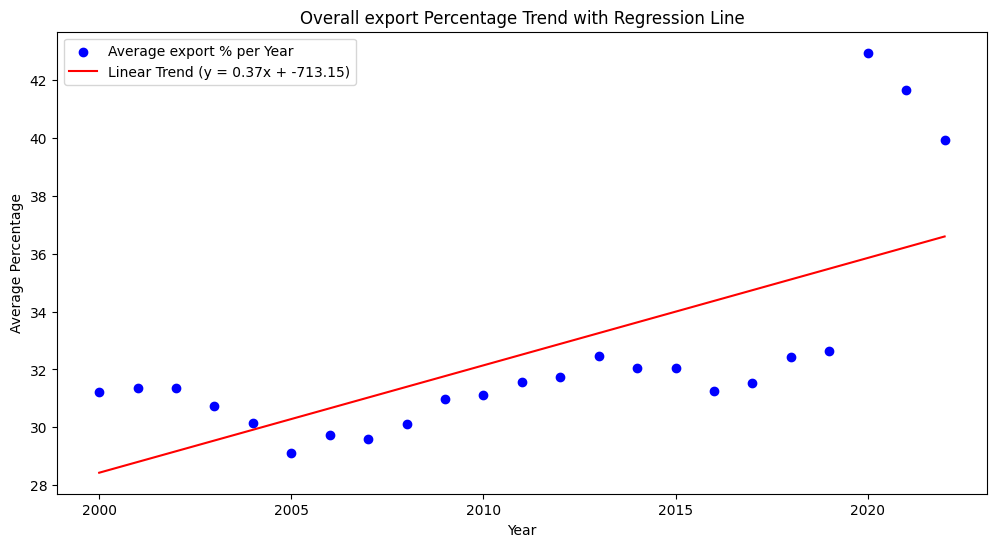

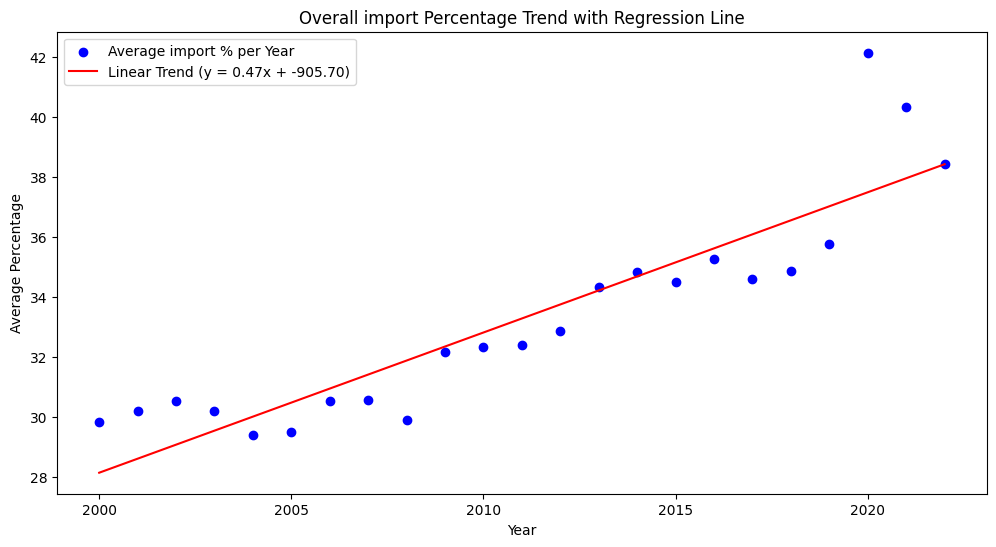

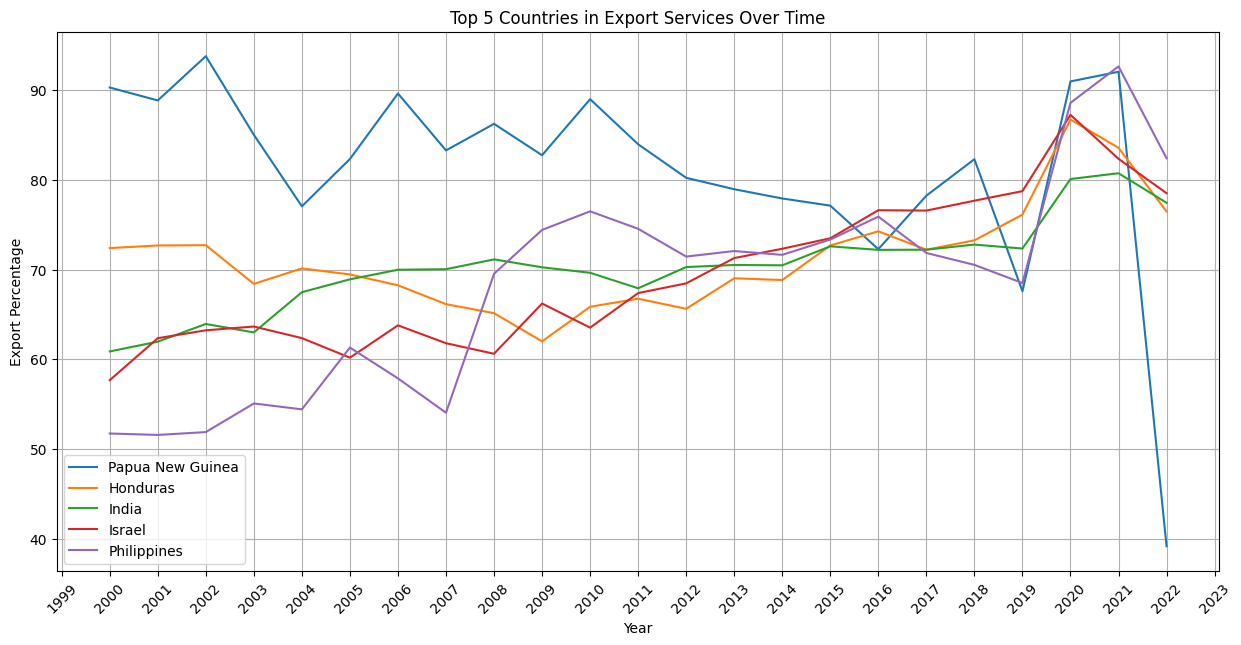

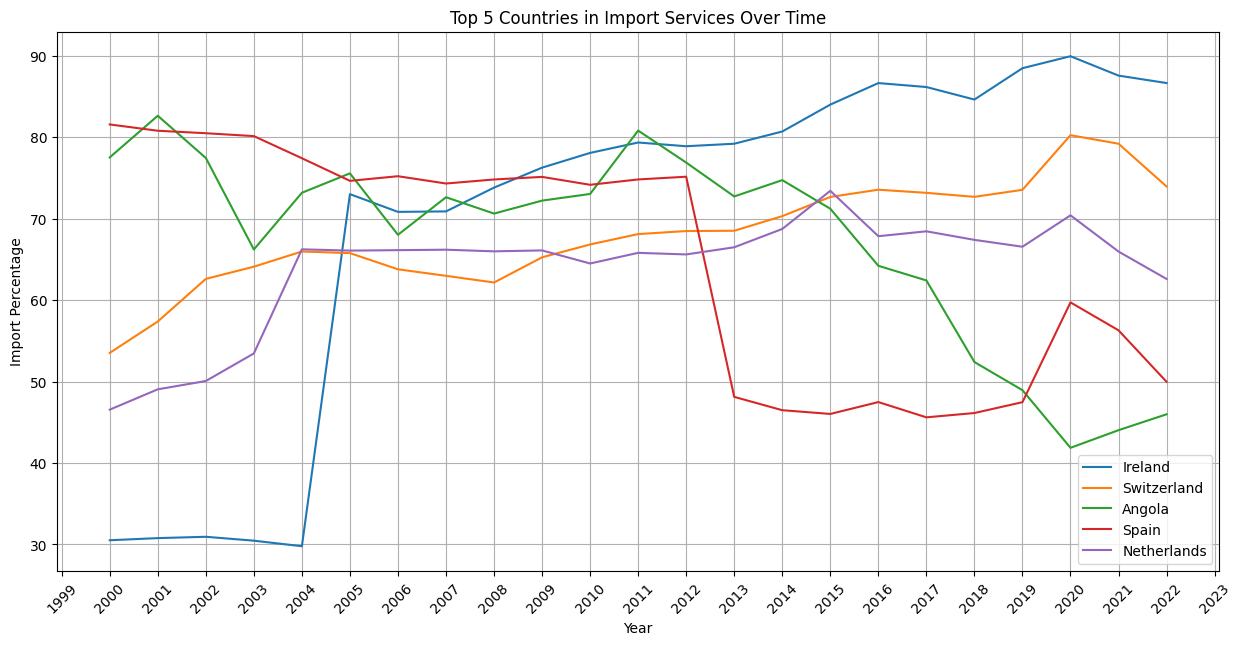

Epoch 1/50
192/192 - 2s - loss: 0.0317 - 2s/epoch - 10ms/step
Epoch 2/50
192/192 - 0s - loss: 0.0093 - 467ms/epoch - 2ms/step
Epoch 3/50
192/192 - 0s - loss: 0.0083 - 468ms/epoch - 2ms/step
Epoch 4/50
192/192 - 0s - loss: 0.0068 - 458ms/epoch - 2ms/step
Epoch 5/50
192/192 - 0s - loss: 0.0063 - 459ms/epoch - 2ms/step
Epoch 6/50
192/192 - 0s - loss: 0.0061 - 458ms/epoch - 2ms/step
Epoch 7/50
192/192 - 0s - loss: 0.0060 - 460ms/epoch - 2ms/step
Epoch 8/50
192/192 - 0s - loss: 0.0059 - 470ms/epoch - 2ms/step
Epoch 9/50
192/192 - 0s - loss: 0.0059 - 444ms/epoch - 2ms/step
Epoch 10/50
192/192 - 0s - loss: 0.0060 - 455ms/epoch - 2ms/step
Epoch 11/50
192/192 - 0s - loss: 0.0059 - 457ms/epoch - 2ms/step
Epoch 12/50
192/192 - 0s - loss: 0.0059 - 474ms/epoch - 2ms/step
Epoch 13/50
192/192 - 0s - loss: 0.0058 - 487ms/epoch - 3ms/step
Epoch 14/50
192/192 - 0s - loss: 0.0059 - 484ms/epoch - 3ms/step
Epoch 15/50
192/192 - 0s - loss: 0.0059 - 467ms/epoch - 2ms/step
Epoch 16/50
192/192 - 0s - loss: 0.0

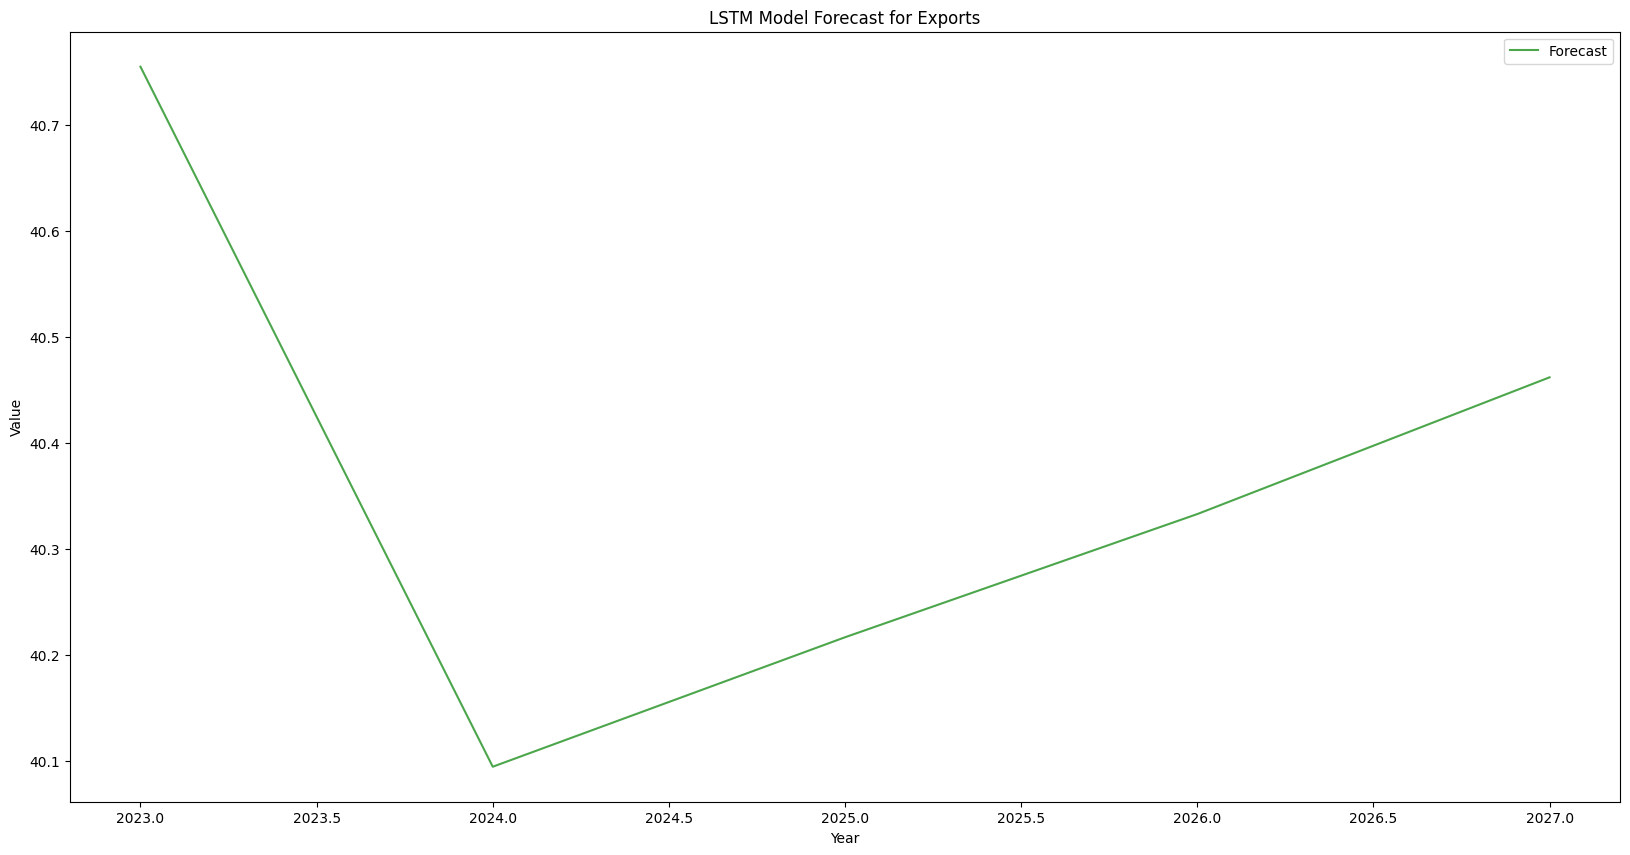

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tkinter import Tk, filedialog

# Function to open a Tkinter file dialog for file selection
def get_file_path():
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(title="Select CSV file", filetypes=[("CSV files", "*.csv")])
    root.destroy()  # Close the Tkinter window
    return file_path

# Function to load and preprocess the data
# Function to load and preprocess the data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.replace('..', pd.NA, inplace=True)
    year_columns = [col for col in data.columns if 'YR' in col]
    for col in year_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    return data

# Function to handle missing values by filling with mean for numeric columns
def handle_missing_values(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
    return df


# Function to reshape data for a specific trend (export/import)
def reshape_data_for_trend(df, trend_type):
    trend_df = df[df['Series Name'].str.contains(trend_type, case=False, na=False)]
    
    reshaped_df = trend_df.melt(id_vars=['Country Name', 'Series Name', 'Series Code'], 
                                value_vars=[col for col in trend_df.columns if 'YR' in col],
                                var_name='Year', value_name='Value')
    
    reshaped_df['Year'] = reshaped_df['Year'].str[:4].astype(int)
    reshaped_df.sort_values(by=['Country Name', 'Year'], inplace=True)

    reshaped_df['Value'] = pd.to_numeric(reshaped_df['Value'], errors='coerce')

    return reshaped_df

# Function to calculate and plot the overall trend for export or import
def plot_overall_trend(df, trend_type):
    trend_df = df.dropna(subset=['Year', 'Value'])  # Drop rows where 'Year' or 'Value' is NaN

    # Group by 'Year' and calculate the mean 'Value'
    mean_trend = trend_df.groupby('Year')['Value'].mean().reset_index()

    # Check if there's enough data
    if len(mean_trend) > 1:
        years = mean_trend['Year'].values.reshape(-1, 1)
        values = mean_trend['Value'].values.reshape(-1, 1)

        # Perform linear regression
        model = LinearRegression()
        model.fit(years, values)
        slope = model.coef_[0][0]
        intercept = model.intercept_[0]

        # Create a line space for plotting the regression line
        line_space = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)

        # Plot the trend line with the regression line
        plt.figure(figsize=(12, 6))
        plt.scatter(years, values, label=f'Average {trend_type} % per Year', color='blue')
        plt.plot(line_space, model.predict(line_space), color='red', label=f'Linear Trend (y = {slope:.2f}x + {intercept:.2f})')
        plt.title(f'Overall {trend_type} Percentage Trend with Regression Line')
        plt.ylabel('Average Percentage')
        plt.xlabel('Year')
        plt.legend()
        plt.show()
    else:
        print(f"Not enough data to plot the overall trend for {trend_type}.")

# Function to get the top N countries based on the average percentage over all years
def get_top_countries(df, series_name_contains, top_n=5):
    filtered_df = df[df['Series Name'].str.contains(series_name_contains, case=False, na=False)]
    # Group by country and calculate the mean
    mean_values = filtered_df.groupby('Country Name')['Value'].mean()
    top_countries = mean_values.nlargest(top_n).index
    return top_countries

# Function to plot top countries for a given series (export/import)
def plot_top_countries(df, series_name_contains, title):
    top_countries = get_top_countries(df, series_name_contains)
    filtered_df = df[(df['Country Name'].isin(top_countries)) & (df['Series Name'].str.contains(series_name_contains))]
    plt.figure(figsize=(15, 7))
    for country in top_countries:
        country_data = filtered_df[filtered_df['Country Name'] == country]
        plt.plot(country_data['Year'], country_data['Value'], label=country)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(f'{series_name_contains.capitalize()} Percentage')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to prepare data for LSTM
def prepare_data_for_lstm(df, column, n_steps):
    data = df[column].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(data)
    X, y = [], []
    for i in range(n_steps, len(data_normalized)):
        X.append(data_normalized[i - n_steps:i, 0])
        y.append(data_normalized[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y, scaler

# Function to create and train LSTM model
def train_lstm_model(X, y, epochs=25):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], 1)),
        LSTM(100, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=2)
    return model

# Example: Open Tkinter file dialog for file selection
file_path = get_file_path()

# Example: Load the data from the selected CSV file and preprocess
df = load_and_preprocess_data(file_path)

# Handle missing values
df = handle_missing_values(df)

# Reshape data for 'export' and 'import' - Adjust 'Your_Target_Column' accordingly
export_df = reshape_data_for_trend(df, 'export')
import_df = reshape_data_for_trend(df, 'import')

# Example: Plot the overall trends for export and import
plot_overall_trend(export_df, 'export')
plot_overall_trend(import_df, 'import')

# Example: Plot the top countries in export and import services
plot_top_countries(export_df, 'export', 'Top 5 Countries in Export Services Over Time')
plot_top_countries(import_df, 'import', 'Top 5 Countries in Import Services Over Time')


# Example: Prepare data for LSTM - Using export data as an example
n_steps = 3
X, y, scaler = prepare_data_for_lstm(export_df, 'Value', n_steps)

# Example: Create and train LSTM model
model = train_lstm_model(X, y, epochs=50)

n_future = 5  # Number of steps you want to predict into the future
forecast_input = X[-1:, :].copy()  # Use the last available X values as input for forecasting
forecast_values = []

for _ in range(n_future):
    forecast_value = model.predict(forecast_input)
    forecast_values.append(forecast_value[0, 0])
    forecast_input = np.roll(forecast_input, shift=-1, axis=1)
    forecast_input[0, -1] = forecast_value[0, 0]

# Inverse transform the forecasted values
forecast_values = scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1))

# Example: Plotting only the forecast as a line
forecast_years = np.arange(export_df['Year'].max() + 1, export_df['Year'].max() + 1 + n_future)
plt.figure(figsize=(20, 10))
plt.plot(forecast_years, forecast_values, label='Forecast', color='green', alpha=0.7)
plt.title('LSTM Model Forecast for Exports')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()




1/1 [==============================] - 0s 18ms/step


C:\Users\serge\AppData\Local\Temp\ipykernel_10172\2302534904.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(forecast_df[country], label=country, shade=True)
C:\Users\serge\AppData\Local\Temp\ipykernel_10172\2302534904.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(forecast_df[country], label=country, shade=True)
C:\Users\serge\AppData\Local\Temp\ipykernel_10172\2302534904.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(forecast_df[country], label=country, shade=True)
C:\Users\serge\AppData\Local\Temp\ipykernel_10172\2302534904.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting 

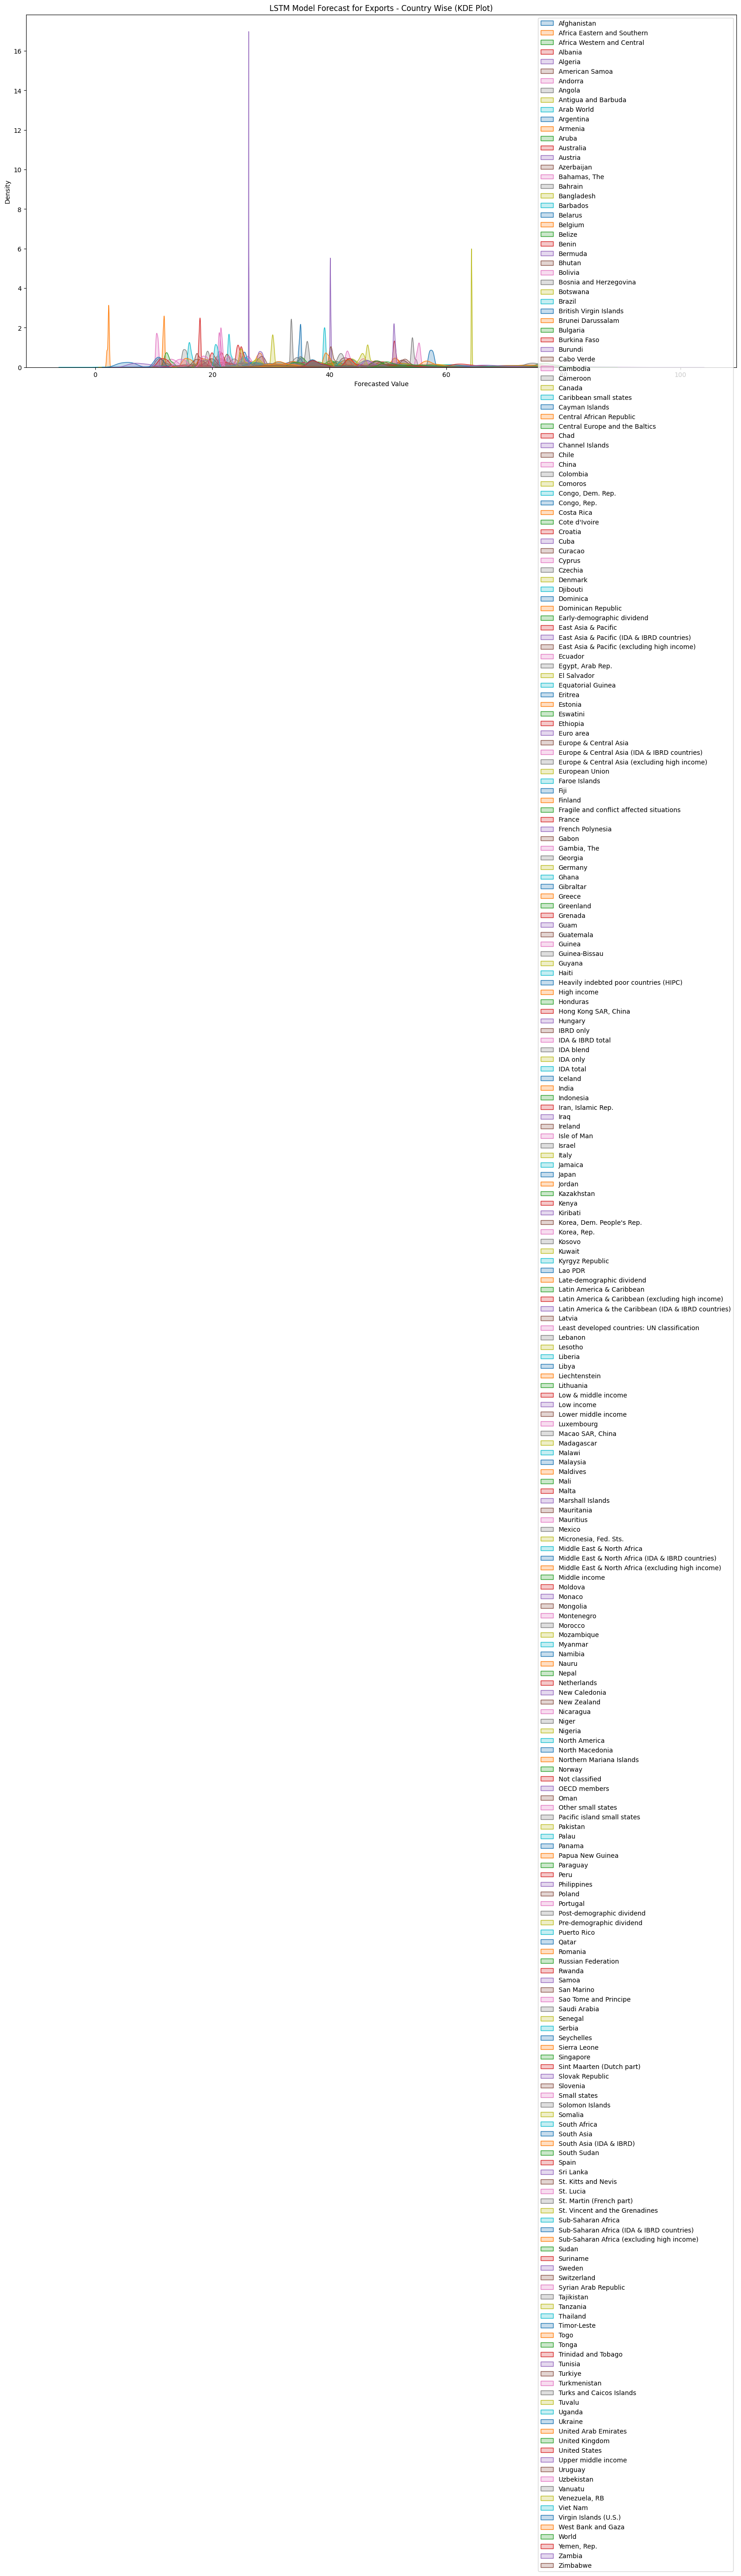

In [17]:
import seaborn as sns

# Example: Forecasting future trends using a loop for each country
n_future = 5  # Number of steps you want to predict into the future

# Create an empty DataFrame to store forecasted values
forecast_df = pd.DataFrame(index=range(n_future), columns=export_df['Country Name'].unique())

for country in export_df['Country Name'].unique():
    # Prepare data for the specific country
    country_data = export_df.loc[export_df['Country Name'] == country, 'Value'].values
    if len(country_data) < n_steps:
        # Skip countries with insufficient data
        continue
    
    X_country, _, scaler_country = prepare_data_for_lstm(pd.DataFrame({'Value': country_data}), 'Value', n_steps)

    forecast_input = X_country[-1:, :].copy()  # Use the last available X values as input for forecasting
    forecast_values = []

    for _ in range(n_future):
        forecast_value = model.predict(forecast_input)
        forecast_values.append(forecast_value[0, 0])
        forecast_input = np.roll(forecast_input, shift=-1, axis=1)
        forecast_input[0, -1] = forecast_value[0, 0]

    # Inverse transform the forecasted values
    forecast_values = scaler_country.inverse_transform(np.array(forecast_values).reshape(-1, 1))

    # Assign the forecasted values to the corresponding columns in the DataFrame
    forecast_df[country] = forecast_values.flatten()

# Example: Creating a KDE plot for forecasted values for each country with different colors
plt.figure(figsize=(20, 10))
for country in forecast_df.columns:
    sns.kdeplot(forecast_df[country], label=country, shade=True)

plt.title('LSTM Model Forecast for Exports - Country Wise (KDE Plot)')
plt.xlabel('Forecasted Value')
plt.ylabel('Density')
plt.legend()
plt.show()



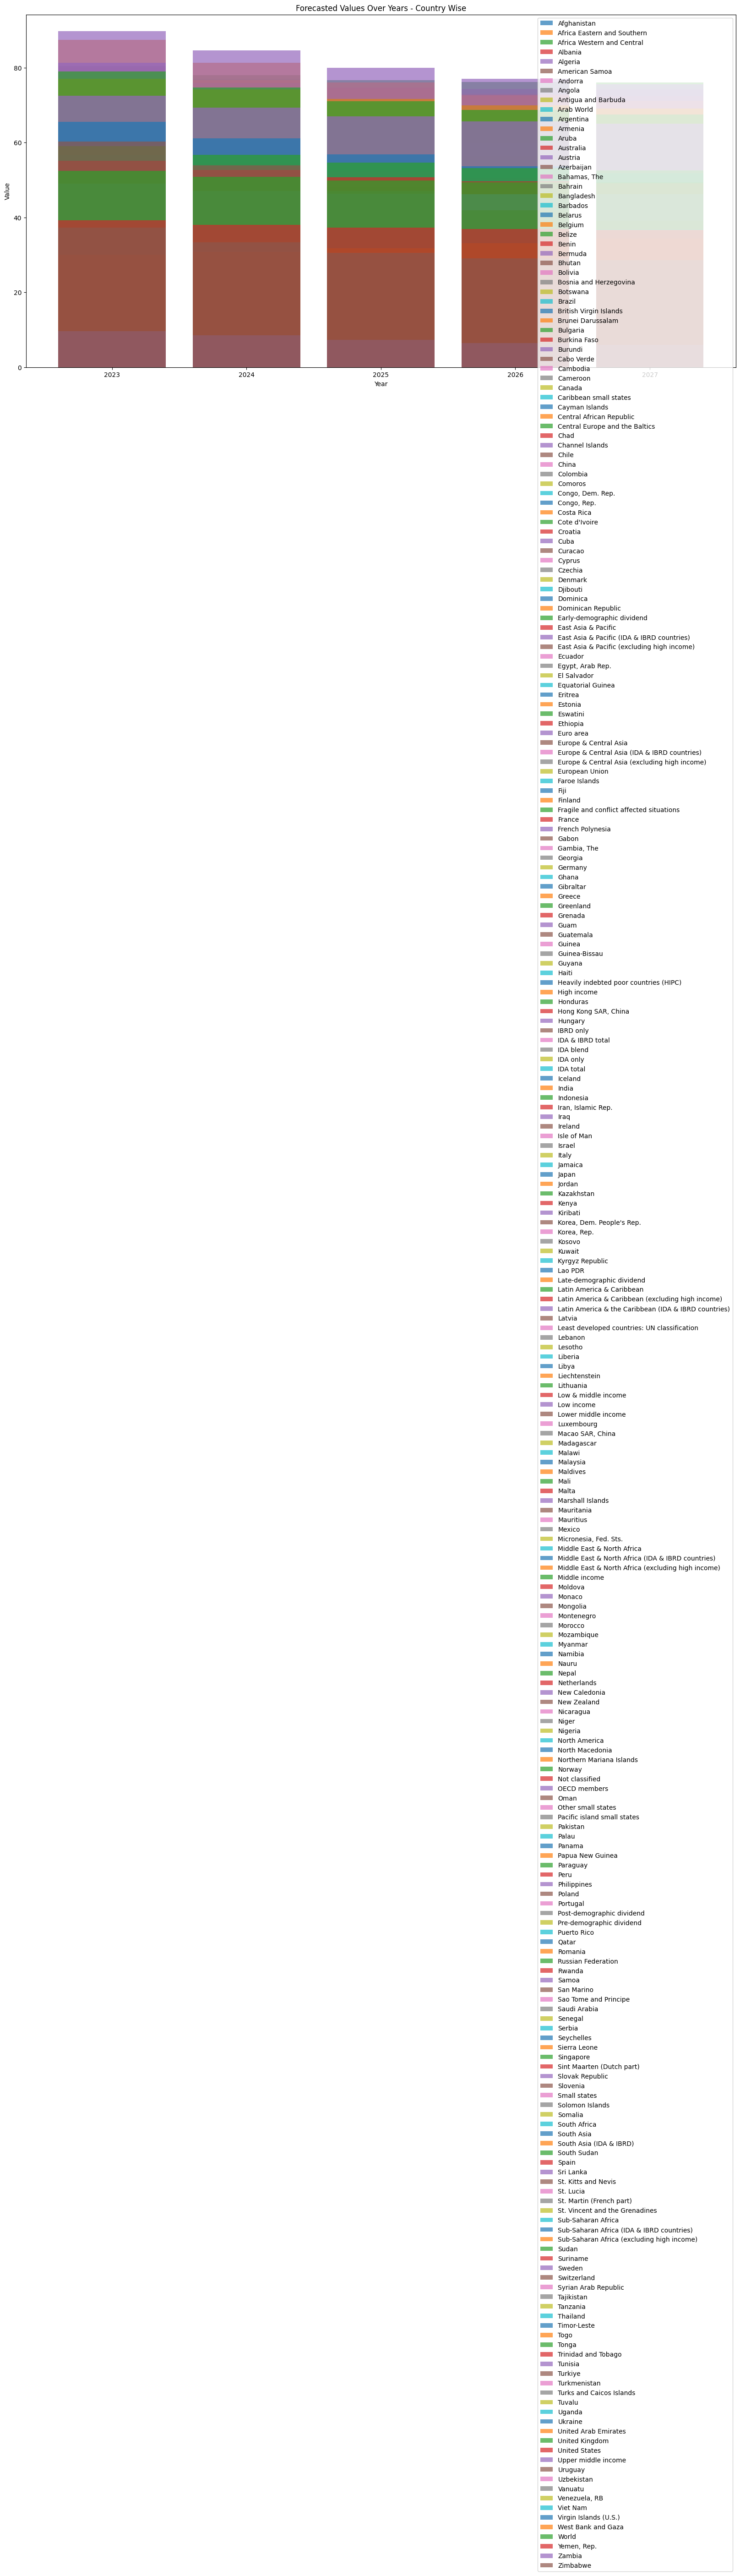

In [14]:
# Example: Creating a histogram for each country over forecasted years
plt.figure(figsize=(20, 10))

# Iterate over unique country names
for country in forecast_df.columns:
    # Prepare data for the specific country
    country_data = forecast_df[country].dropna().values
    
    # Get the corresponding years
    years = range(export_df['Year'].max() + 1, export_df['Year'].max() + 1 + n_future)
    
    # Plot bars for each year
    plt.bar(years, country_data, alpha=0.7, label=country)

plt.title('Forecasted Values Over Years - Country Wise')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

